# Crime & Schools Analysis in Chicago (SQL + SQLite)

**Goal:**  
Explore the relationship between crime levels and school characteristics in Chicago using SQL and a local SQLite database.

**Key questions:**
- Which neighborhoods have the highest number of crimes?  
- How do school indicators (ratings, academic performance, environment) correlate with the crime level in the area?

**Data:**  
- `chicago_crime_data` — records of crimes in Chicago.  
- `chicago_public_schools` — data on Chicago public schools.  
- Common join key: `COMMUNITY_AREA_NUMBER`.

**Notebook contents:**
1. Connecting to the `socioeconomic.db` database.  
2. Loading/updating crime and school tables (CSV → SQLite).  
3. Basic SQL analysis for each table.  
4. JOIN queries (crime × schools).  
5. Visualization and conclusions.


## 1. Environment Setup

Import the necessary libraries and enable the **SQL magic** extension for Jupyter.  
This allows you to run SQL queries directly inside notebook cells.


In [16]:
# Import libraries
import sqlite3
import pandas as pd
import prettytable
import matplotlib.pyplot as plt
import seaborn as sns

# Configure prettytable for nicer output
prettytable.DEFAULT = 'DEFAULT'

# Enable SQL magic in Jupyter
%load_ext sql


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## 2. Creating or Connecting to the Database

We will use the same **socioeconomic.db** database so that all data (socio-economic indicators, crimes, and schools) is stored in one place.  
This setup makes it possible to run more complex queries with table joins (JOIN).


In [17]:
# Create or connect to the database
con = sqlite3.connect("../socioeconomic.db")
cur = con.cursor()


## 3. Loading data into tables

We will add three datasets to the **socioeconomic.db** database:  

- **CHICAGO_CENSUS_DATA** — census data;  
- **CHICAGO_PUBLIC_SCHOOLS** — public school performance data;  
- **CHICAGO_CRIME_DATA** — crime records.  

Before saving, we will do some light preparation:  
- replace spaces in column names with `_`,  
- save the data to SQLite using `to_sql`.  


In [18]:
### Loading the data into SQLite
# Census data
df = pd.read_csv("../data/ChicagoCensusData.csv")
df.columns = df.columns.str.replace(" ", "_")
df.to_sql("CHICAGO_CENSUS_DATA", con, if_exists="replace", index=False, method="multi")

# Public school data
df = pd.read_csv("../data/ChicagoPublicSchools.csv")
df.columns = df.columns.str.replace(" ", "_")
df.to_sql("CHICAGO_PUBLIC_SCHOOLS", con, if_exists="replace", index=False, method="multi")

# Crime data
df = pd.read_csv("../data/ChicagoCrimeData.csv")
df.columns = df.columns.str.replace(" ", "_")
df.to_sql("CHICAGO_CRIME_DATA", con, if_exists="replace", index=False, method="multi")



533

## 4. Connecting SQL magic to the database

Now let’s connect SQL magic to our **socioeconomic.db** database so that we can run SQL queries directly from notebook cells.


In [19]:
%sql sqlite:///../socioeconomic.db


### 4.1. How many crimes are there?

First, let’s check the total number of records in the **CHICAGO_CRIME_DATA** table to understand the size of the crime dataset.


In [20]:
%sql SELECT COUNT(*) FROM CHICAGO_CRIME_DATA;


 * sqlite:///../socioeconomic.db
Done.


COUNT(*)
533


👉 The dataset contains **533 crime cases (records)**.

### 4.2. Top 5 Neighborhoods by Poverty  

Query the Chicago neighborhoods with the highest percentage of households living below the poverty line:

In [21]:
%%sql
SELECT COMMUNITY_AREA_NAME
FROM CHICAGO_CENSUS_DATA
ORDER BY PERCENT_HOUSEHOLDS_BELOW_POVERTY DESC
LIMIT 5;


 * sqlite:///../socioeconomic.db
Done.


COMMUNITY_AREA_NAME
Riverdale
Fuller Park
Englewood
North Lawndale
East Garfield Park


The **Top 5 Chicago neighborhoods** with the highest percentage of households living below the poverty line are:  

- **Riverdale**  
- **Fuller Park**  
- **Englewood**  
- **North Lawndale**  
- **East Garfield Park**  

These areas are the most socio-economically vulnerable.  
High poverty levels here are directly linked to other issues such as:  
- low per-capita income,  
- high unemployment rates,  
- a high *Hardship Index*.  

👉 Therefore, these neighborhoods face the greatest difficulties and should be prioritized for social and economic support programs.


### 4.3. Neighborhood with the Highest Hardship Index  

Let's identify the Chicago neighborhood with the **highest Hardship Index** (the indicator of socio-economic distress).  


In [22]:
%%sql SELECT COMMUNITY_AREA_NAME 
FROM CHICAGO_CENSUS_DATA 
ORDER BY HARDSHIP_INDEX DESC 
LIMIT 1;


 * sqlite:///../socioeconomic.db
Done.


COMMUNITY_AREA_NAME
Riverdale


The neighborhood with the highest **Hardship Index** is **Riverdale**.  
This index reflects a combination of unfavorable factors such as low income, high poverty and unemployment rates, and low education levels.  

👉 The fact that **Riverdale** ranks first indicates the most challenging socio-economic conditions among all Chicago neighborhoods.  


### 4.4. Name of the Neighborhood with the Highest Number of Crimes  

Now let's identify the name of the neighborhood with the highest number of recorded crimes.  
To do this, we’ll join the crime data with the census data using the community area number.  


In [23]:
%%sql
SELECT ccd.COMMUNITY_AREA_NAME,
       COUNT(*) AS crime_count
FROM CHICAGO_CRIME_DATA AS cr
JOIN CHICAGO_CENSUS_DATA AS ccd
  ON cr.COMMUNITY_AREA_NUMBER = ccd.COMMUNITY_AREA_NUMBER
GROUP BY ccd.COMMUNITY_AREA_NAME
ORDER BY crime_count DESC
LIMIT 1;


 * sqlite:///../socioeconomic.db
Done.


COMMUNITY_AREA_NAME,crime_count
Austin,43


The neighborhood with the highest number of crimes is **Austin**.  

High criminal activity here goes hand in hand with adverse social factors:  
- high poverty rates,  
- low income levels,  
- and a high *Hardship Index*.  

👉 **Austin** is a key risk zone requiring priority attention and comprehensive measures to improve both the social and crime situation.  


### 4.5. Schools in Neighborhoods with the Highest Hardship Index  

Let’s see how social difficulties (high *Hardship Index*) affect school attendance.  
To do this, we join the **CHICAGO_PUBLIC_SCHOOLS** and **CHICAGO_CENSUS_DATA** tables by the community area number.  

In [24]:
%%sql SELECT C.NAME_OF_SCHOOL,
           C.COMMUNITY_AREA_NAME,
           C.AVERAGE_STUDENT_ATTENDANCE,
           CS.HARDSHIP_INDEX
FROM CHICAGO_PUBLIC_SCHOOLS AS C
JOIN CHICAGO_CENSUS_DATA AS CS
  ON C.COMMUNITY_AREA_NUMBER = CS.COMMUNITY_AREA_NUMBER
WHERE CS.HARDSHIP_INDEX = (SELECT MAX(HARDSHIP_INDEX) FROM CHICAGO_CENSUS_DATA);


 * sqlite:///../socioeconomic.db
Done.


NAME_OF_SCHOOL,COMMUNITY_AREA_NAME,AVERAGE_STUDENT_ATTENDANCE,HARDSHIP_INDEX
George Washington Carver Military Academy High School,RIVERDALE,91.60%,98.0
George Washington Carver Primary School,RIVERDALE,90.90%,98.0
Ira F Aldridge Elementary School,RIVERDALE,92.90%,98.0
William E B Dubois Elementary School,RIVERDALE,93.30%,98.0


The query selects schools located in the neighborhood with the highest Hardship Index (**98**) — **Riverdale**.  
Four schools appear in the result:

- **George Washington Carver Military Academy High School** — attendance 91.6%  
- **George Washington Carver Primary School** — attendance 90.9%  
- **Ira F Aldridge Elementary School** — attendance 92.9%  
- **William E B Dubois Elementary School** — attendance 93.3%  

Despite the extremely high level of socio-economic hardship (*Hardship Index = 98*), school attendance remains quite high — from about 91% to 93%.

👉 This may suggest that:  
- school education in Riverdale is seen as an important way out of poverty;  
- the education system maintains high compulsory attendance even in disadvantaged areas;  
- however, behind these numbers there may be hidden issues of education quality (lack of resources, low safety, etc.) that are not directly reflected in the attendance figures.  


### 4.6. Top-10 Neighborhoods by Number of Crimes Near Schools  

Let's find out which Chicago neighborhoods have recorded the highest number of crimes committed **on school grounds or nearby**.  
We’ll filter by `LOCATION_DESCRIPTION` and group by neighborhood.  


In [25]:
%%sql SELECT C.COMMUNITY_AREA_NAME, 
       COUNT(CH.CASE_NUMBER) AS school_crimes 
FROM CHICAGO_PUBLIC_SCHOOLS AS C 
JOIN CHICAGO_CRIME_DATA AS CH 
  ON C.COMMUNITY_AREA_NUMBER = CH.COMMUNITY_AREA_NUMBER 
WHERE CH.LOCATION_DESCRIPTION LIKE '%SCHOOL%' 
GROUP BY C.COMMUNITY_AREA_NAME 
ORDER BY school_crimes DESC 
LIMIT 10;


 * sqlite:///../socioeconomic.db
Done.


COMMUNITY_AREA_NAME,school_crimes
AUSTIN,46
ASHBURN,16
EAST GARFIELD PARK,13
DOUGLAS,11
SOUTH SHORE,9
BRIGHTON PARK,8
ROGERS PARK,6
LINCOLN SQUARE,5


The query counts the number of crimes committed **near schools**  
(`LOCATION_DESCRIPTION LIKE '%SCHOOL%'`) and outputs the **top 10 neighborhoods**:

- **Austin** — 46 crimes  
- **Ashburn** — 16  
- **East Garfield Park** — 13  
- **Douglas** — 11  
- **South Shore** — 9  
- **Brighton Park** — 8  
- **Rogers Park** — 6  
- **Lincoln Square** — 5  

👉 **Key takeaways:**  
- **Austin** stands out sharply: crimes near schools here are almost **3× higher** than in the second-place neighborhood (**Ashburn**).  
- Other areas show much lower values, indicating that school-related crime is concentrated in specific locations.  
- This situation may point to serious **safety issues** around schools in **Austin**: high criminal activity near educational institutions threatens not only students but the community as a whole.  

These data can be used to design **targeted measures to strengthen school security** in the most vulnerable neighborhoods.


### 4.7. Most problematic neighborhoods: high crime + low school attendance  

Now let's identify neighborhoods where **two risk factors** coincide:  
- **High crime rate**,  
- **Low school attendance**.  

To do this, we join the tables **CHICAGO_CRIME_DATA**, **CHICAGO_PUBLIC_SCHOOLS**, and **CHICAGO_CENSUS_DATA**.  
We count the number of crimes per neighborhood and compare it with the **average school attendance**.


In [26]:
%%sql SELECT CS.COMMUNITY_AREA_NAME, 
       COUNT(CH.CASE_NUMBER) AS total_crimes, 
       ROUND(AVG(C.AVERAGE_STUDENT_ATTENDANCE), 2) AS avg_attendance 
FROM CHICAGO_CENSUS_DATA AS CS 
JOIN CHICAGO_CRIME_DATA AS CH 
  ON CS.COMMUNITY_AREA_NUMBER = CH.COMMUNITY_AREA_NUMBER 
JOIN CHICAGO_PUBLIC_SCHOOLS AS C 
  ON CS.COMMUNITY_AREA_NUMBER = C.COMMUNITY_AREA_NUMBER 
GROUP BY CS.COMMUNITY_AREA_NAME 
HAVING avg_attendance < 90 
ORDER BY total_crimes DESC 
LIMIT 10;


 * sqlite:///../socioeconomic.db
Done.


COMMUNITY_AREA_NAME,total_crimes,avg_attendance
Austin,989,89.73
Englewood,357,89.45
West Englewood,156,89.99
East Garfield Park,104,89.74
Woodlawn,64,89.39
Douglas,55,89.14
Pullman,15,89.32
West Elsdon,12,89.83
Hermosa,12,89.75
Avalon Park,12,84.53


The query identifies neighborhoods with **high crime rates** and **low school attendance** (average value below 90%).  

**Results:**  
- **Austin** — 989 crimes, attendance 89.7%  
- **Englewood** — 357 crimes, attendance 89.5%  
- **West Englewood** — 156 crimes, attendance 89.9%  
- **Avalon Park** — lowest attendance 84.5%  

👉 **Key takeaways:**  
- *Austin* is the leader in crime and one of the most problematic neighborhoods.  
- *Englewood* and *West Englewood* are also critical: high crime + low student engagement.  
- *Avalon Park* stands out with the **lowest attendance (84.5%)**.  
- Even neighborhoods with fewer crimes (Pullman, Hermosa, West Elsdon) show weak attendance.  

This analysis highlights the areas where both **security measures** and **educational support** need to be strengthened at the same time.


### 4.8. Neighborhoods with Low Income or High Hardship Index — “Risk List”

We compile a unified list of socially vulnerable neighborhoods in Chicago.  
**Inclusion criteria:**  
- `LOW_INCOME`: per capita income < $11,000  
- `HIGH_HARDSHIP`: hardship index > 80  

In [27]:
%%sql SELECT COMMUNITY_AREA_NUMBER, 
       COMMUNITY_AREA_NAME, 
       'LOW_INCOME' AS flag 
FROM CHICAGO_CENSUS_DATA 
WHERE PER_CAPITA_INCOME_ < 11000 
UNION 
SELECT COMMUNITY_AREA_NUMBER, 
       COMMUNITY_AREA_NAME, 
       'HIGH_HARDSHIP' AS flag 
FROM CHICAGO_CENSUS_DATA 
WHERE HARDSHIP_INDEX > 80 
ORDER BY COMMUNITY_AREA_NUMBER, flag;


 * sqlite:///../socioeconomic.db
Done.


COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,flag
23.0,Humboldt park,HIGH_HARDSHIP
26.0,West Garfield Park,HIGH_HARDSHIP
26.0,West Garfield Park,LOW_INCOME
27.0,East Garfield Park,HIGH_HARDSHIP
29.0,North Lawndale,HIGH_HARDSHIP
30.0,South Lawndale,HIGH_HARDSHIP
30.0,South Lawndale,LOW_INCOME
34.0,Armour Square,HIGH_HARDSHIP
37.0,Fuller Park,HIGH_HARDSHIP
37.0,Fuller Park,LOW_INCOME


The query generates a “risk list” of neighborhoods that meet at least one criterion:  
- low per capita income (< $11,000),  
- high Hardship Index (> 80).  

**Examples:**  
- **Humboldt Park** — HIGH_HARDSHIP.  
- **West Garfield Park** — meets both criteria (LOW_INCOME + HIGH_HARDSHIP).  
- **East Garfield Park, North Lawndale, South Lawndale** — HIGH_HARDSHIP.  

👉 Special attention should be given to areas meeting **both** conditions (e.g., West Garfield Park).  


### 4.9. Ranking Neighborhoods by Crime (Window Functions)

To rank neighborhoods by the number of crimes, we use SQL window functions.  
They allow us to build a ranking with classic metrics:

- **RANK()** — assigns positions with gaps (if two neighborhoods share 1st place, the next gets 3rd).  
- **DENSE_RANK()** — similar to `RANK()`, but without gaps in numbering.  


In [28]:
%%sql
WITH crime_by_area AS (
    SELECT COMMUNITY_AREA_NUMBER,
           COUNT(*) AS crime_count
    FROM CHICAGO_CRIME_DATA
    GROUP BY COMMUNITY_AREA_NUMBER
)
SELECT COMMUNITY_AREA_NUMBER,
       crime_count,
       RANK() OVER (ORDER BY crime_count DESC)  AS rank_by_crime,
       DENSE_RANK() OVER (ORDER BY crime_count DESC)  AS dense_rank_by_crime
FROM crime_by_area
ORDER BY rank_by_crime
LIMIT 20;


 * sqlite:///../socioeconomic.db
Done.


COMMUNITY_AREA_NUMBER,crime_count,rank_by_crime,dense_rank_by_crime
None,43,1,1
25.0,43,1,1
23.0,22,3,2
68.0,21,4,3
28.0,16,5,4
29.0,16,5,4
8.0,15,7,5
71.0,14,8,6
24.0,13,9,7
66.0,12,10,8


### Findings

- **Top crime leaders** — Neighborhood **№25** and the **undefined area (None)**: each has **43 crimes** recorded.  
  They both hold 1st place in the ranking.  
- **Neighborhood №23** is 3rd (22 crimes), and **№68** is 4th (21 crimes).  
- Then we see a group of neighborhoods with similar crime levels:  
  - №28 and №29 (16 crimes each, tied for 5th place).  
  - №8 (15 crimes, 7th place).  
  - №71 (14 crimes, 8th place).  
- Starting from 10th place, the number of crimes drops sharply to the **9–12** range.  

👉 **Thus:**  
- This method highlights not only the **leaders in crime**, but also groups neighborhoods with the same values.  
- We can clearly see “**risk clusters**” (for example, №28 and №29) with identical numbers of incidents.  


### 4.10. Neighborhoods with High Poverty and Low School Safety  

Identify neighborhoods where both conditions are met:  
- More than **25% of households live below the poverty line**,  
- Schools show a **low average safety score**.  

We use two CTEs (Common Table Expressions):  
- `school_safety` → calculates the average `SAFETY_SCORE` per neighborhood,  
- `poverty` → retrieves the % of households below the poverty line.  

Then we join these CTEs and rank neighborhoods by poverty and low safety to highlight the most at-risk areas.  


In [29]:
%%sql WITH school_safety AS ( 
    SELECT COMMUNITY_AREA_NUMBER, 
           ROUND(AVG(SAFETY_SCORE), 2) AS avg_safety 
    FROM CHICAGO_PUBLIC_SCHOOLS 
    WHERE SAFETY_SCORE IS NOT NULL 
    GROUP BY COMMUNITY_AREA_NUMBER 
), 
poverty AS ( 
    SELECT COMMUNITY_AREA_NUMBER, 
           COMMUNITY_AREA_NAME, 
           PERCENT_HOUSEHOLDS_BELOW_POVERTY 
    FROM CHICAGO_CENSUS_DATA 
) 
SELECT p.COMMUNITY_AREA_NAME, 
       p.PERCENT_HOUSEHOLDS_BELOW_POVERTY, 
       s.avg_safety, 
       RANK() OVER (ORDER BY p.PERCENT_HOUSEHOLDS_BELOW_POVERTY DESC) AS poverty_rank, 
       RANK() OVER (ORDER BY s.avg_safety ASC)  AS low_safety_rank 
FROM poverty p 
JOIN school_safety s 
  ON p.COMMUNITY_AREA_NUMBER = s.COMMUNITY_AREA_NUMBER 
WHERE p.PERCENT_HOUSEHOLDS_BELOW_POVERTY > 25 
ORDER BY p.PERCENT_HOUSEHOLDS_BELOW_POVERTY DESC, s.avg_safety ASC 
LIMIT 20;


 * sqlite:///../socioeconomic.db
Done.


COMMUNITY_AREA_NAME,PERCENT_HOUSEHOLDS_BELOW_POVERTY,avg_safety,poverty_rank,low_safety_rank
Riverdale,56.5,41.0,1,17
Fuller Park,51.2,35.5,2,12
Englewood,46.6,34.06,3,10
North Lawndale,43.1,49.27,4,23
East Garfield Park,42.4,49.46,5,24
Washington Park,42.1,25.4,6,1
West Garfield Park,41.7,37.25,7,13
Armour Square,40.1,43.33,8,21
West Englewood,34.4,31.17,9,4
Humboldt park,33.9,41.1,10,18


The query compares two key indicators:  
- % of households below the poverty line (`PERCENT_HOUSEHOLDS_BELOW_POVERTY`),  
- average school safety score (`avg_safety`).  

**Top-3 neighborhoods:**  
- **Riverdale** — poverty 56.5%, safety 41.0  
- **Fuller Park** — poverty 51.2%, safety 35.5  
- **Englewood** — poverty 46.6%, safety 34.1  

👉 **Conclusion:**  
These neighborhoods combine high poverty with low school safety and therefore require **priority intervention**.  


As part of the analysis of Chicago neighborhoods, the relationship between **poverty levels** and **school safety** was examined.  
For this purpose, the following metrics were calculated:  

- the percentage of households below the poverty line (from census data),  
- the average school safety score (from school data).  

Only neighborhoods where **more than 25% of households live in poverty** were included in the sample.  

The results are shown on a scatter plot:  
- **X-axis** — poverty level,  
- **Y-axis** — average school safety score.  


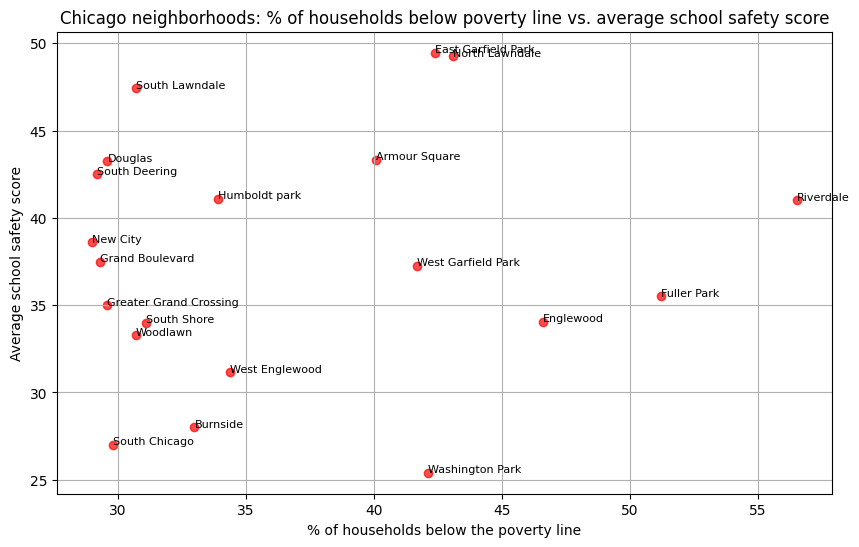

In [30]:
# Execute the query and save the result into a DataFrame
query = """
WITH school_safety AS (
    SELECT COMMUNITY_AREA_NUMBER,
           ROUND(AVG(SAFETY_SCORE), 2) AS avg_safety
    FROM CHICAGO_PUBLIC_SCHOOLS
    WHERE SAFETY_SCORE IS NOT NULL
    GROUP BY COMMUNITY_AREA_NUMBER
),
poverty AS (
    SELECT COMMUNITY_AREA_NUMBER,
           COMMUNITY_AREA_NAME,
           PERCENT_HOUSEHOLDS_BELOW_POVERTY
    FROM CHICAGO_CENSUS_DATA
)
SELECT p.COMMUNITY_AREA_NAME,
       p.PERCENT_HOUSEHOLDS_BELOW_POVERTY AS poverty,
       s.avg_safety
FROM poverty p
JOIN school_safety s
  ON p.COMMUNITY_AREA_NUMBER = s.COMMUNITY_AREA_NUMBER
WHERE p.PERCENT_HOUSEHOLDS_BELOW_POVERTY > 25
ORDER BY p.PERCENT_HOUSEHOLDS_BELOW_POVERTY DESC, s.avg_safety ASC
LIMIT 20;
"""

df = pd.read_sql_query(query, con)

# Build scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df['poverty'], df['avg_safety'], c='red', alpha=0.7)

# Add point labels
for i, txt in enumerate(df['COMMUNITY_AREA_NAME']):
    plt.annotate(txt, 
                 (df['poverty'][i], df['avg_safety'][i]), 
                 fontsize=8)

plt.title("Chicago neighborhoods: % of households below poverty line vs. average school safety score")
plt.xlabel("% of households below the poverty line")
plt.ylabel("Average school safety score")
plt.grid(True)

plt.savefig("../images/poverty_vs_school_safety.svg")

plt.show()


## 📊 Conclusions from the Scatter Plot  
**Chicago Neighborhoods: % of Households Below Poverty vs. Average School Safety**

- **No strict correlation:** high poverty does not always mean low school safety.  
  *Example:* Riverdale (~56% poor, safety ~41).

- **Low safety with high poverty:**  
  Washington Park (min. safety ~25 at ~42% poor),  
  Burnside, South Chicago, West Englewood (medium-high poverty, low safety).

- **Exceptions (high poverty + high safety):**  
  East Garfield Park, North Lawndale (safety 49 at 43% poor),  
  South Lawndale (~47 at ~30% poor).

- **Overall trend:**  
  With low and medium poverty, average-to-high safety is more common;  
  With high poverty, the range widens — both very low and relatively high safety scores occur.

✅ **Summary:** most high-poverty neighborhoods show low or medium school safety, but there are exceptions with relatively high safety despite high poverty.

---

## 📝 Final Conclusion on the Chicago Data Study  

The analysis of crime, schools, and socio-economic indicators revealed a systemic pattern:  
**poverty → social vulnerability → crime ↔ lower school safety.**

- **Key risk neighborhoods:** Riverdale, Fuller Park, Englewood, North Lawndale, East Garfield Park, Austin, West Garfield Park.  
- **Typical characteristics:** low per-capita income (<$11k), high % of households below poverty, critical Hardship Index, wide spectrum of offenses.  
- **School environment:** schools in these neighborhoods are more often subject to incidents despite high attendance.  
- **Window functions (RANK/DENSE_RANK):** identify “risk clusters” — several neighborhoods with the same crime levels occupy adjacent positions in the ranking.

**Overall takeaway:** the data confirm the link between poverty, school environment vulnerability, and crime. These neighborhoods should be prioritized for social programs:  
— poverty reduction measures;  
— targeted improvement of school safety;  
— focused anti-crime initiatives.

💡 **Bottom line:** integrating census, school, and crime data makes it possible to identify patterns and design comprehensive strategies for sustainable urban development.
